In [1]:
import sys
sys.path.append("../script/")

import Functions
from Engine import Engine


from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import numpy as np
import pandas as pd
from time import time

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# data

In [6]:
from sklearn.datasets import load_digits
mnist = load_digits()

X = pd.DataFrame(mnist.data).values
y = pd.DataFrame(mnist.target).values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=30,stratify=y)

In [7]:
pd.value_counts(y_train)

9    3
8    3
5    3
6    3
3    3
0    3
7    3
2    3
4    3
1    3
Name: count, dtype: int64

In [5]:
from sklearn.datasets import fetch_openml
dataset = fetch_openml("mnist_784") 

c:\Users\zhouz\anaconda3\envs\BStackGP\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


KeyboardInterrupt: 

In [147]:
X = dataset['data'].values
y = dataset['target'].values.astype('int')

seed = np.random.randint(9999999)
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7, test_size=0.3, random_state=seed)

# model

In [9]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p
    
def update_log_p(grads,log_odds,p,learning_rate):
    tor = 16

    log_odds_1 = log_odds + learning_rate * grads
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < tor,out=np.zeros(log_odds_1.shape)+tor)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < tor,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for node in stack:
        grads = node.predict_grad(X)
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

In [10]:
train_acc = []
test_acc = []

stack = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

In [11]:
learning_rate = 0.3
bins = 2
lam = 0
stack = []
losses = []
num_features = X_train.shape[1]

max_depth = 4
tolerance = 0.01


total_size = 10
elite_size = 10

eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,learning_rate,bins,max_depth,lam)
eg.initialize_nodes(log_odds,p)
origin_features = eg.nodes.copy()
origin_losses = eg.losses.copy()

stack.extend(eg.nodes)
losses.extend(origin_losses)

for i in range(1000):
    for j in range(4):
        eg.evolve(total_size,elite_size,log_odds=log_odds,p=p,tolerance=tolerance,verbose=0)
    stack,losses = eg.adding_unique_node(stack,losses,eg.nodes[num_features:],tolerance=tolerance)
    eg.nodes = origin_features.copy()
    eg.losses = origin_losses.copy()
    print(len(stack),sum([n.numNode for n in stack]),i)
    # if len(stack) > 8000:
    #         break


91 159 0
120 262 1
147 367 2
170 454 3
198 546 4
226 656 5
255 753 6
278 832 7
302 924 8
325 1009 9
348 1086 10
380 1198 11
404 1280 12
428 1368 13
452 1462 14
480 1562 15
503 1649 16
529 1739 17
550 1808 18
575 1895 19
598 1980 20
626 2088 21
652 2176 22
675 2261 23
694 2328 24
721 2421 25
749 2527 26
772 2614 27
801 2719 28
826 2814 29
847 2893 30
868 2964 31
891 3055 32
914 3136 33
932 3194 34
954 3278 35
974 3342 36
999 3437 37
1021 3525 38
1042 3604 39
1062 3682 40
1089 3783 41
1111 3875 42
1133 3957 43
1154 4040 44
1178 4118 45
1200 4200 46
1228 4324 47
1250 4400 48
1275 4493 49
1301 4597 50
1319 4665 51
1341 4743 52
1362 4824 53
1381 4905 54
1399 4965 55
1423 5053 56
1436 5096 57
1461 5199 58
1486 5292 59
1504 5356 60
1524 5426 61
1552 5528 62
1576 5618 63
1597 5697 64
1621 5779 65
1645 5869 66
1667 5949 67
1683 6001 68
1710 6102 69
1735 6199 70
1750 6256 71
1774 6360 72
1798 6468 73
1820 6554 74
1840 6638 75
1859 6707 76
1885 6801 77
1904 6866 78
1922 6928 79
1937 6983 80
1954 

KeyboardInterrupt: 

In [12]:
y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

fits = [i.estimator.loss for i in stack]
a = [stack[i] for i in np.argsort(fits)]

log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

train_acc = []
test_acc = []

train_sse = []
test_sse = []

counts = []


alpha  = 0
beta   = 1
gammer = 0
for _ in range(20):
    score = []
    
    for i,node in enumerate(a):
        # node.estimator.lam =  0
        node.estimator.lam =  0 + beta * node.numNode + gammer * node.depth
        grads = node.estimator.set_grads_bin(y_train_one_hot-p,p,alpha)
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

        test_grads = node.predict_grad(X_test)
        test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)
        
        # p = (p.T/np.sum(p,axis=1)).T
        # test_p = (test_p.T/np.sum(test_p,axis=1)).T

        train_sse.append(np.sum(np.power(y_train_one_hot - (p.T/np.sum(p,axis=1)).T,2)))
        test_sse.append(np.sum(np.power(y_test_one_hot - (test_p.T/np.sum(test_p,axis=1)).T,2)))
        # score.append(previous_sse - train_sse[-1])
        # previous_sse = train_sse[-1]


        pred = np.argmax(p,axis=1)
        train_acc.append(accuracy_score(pred,y_train))
        test_pred = np.argmax(test_p,axis=1)
        test_acc.append(accuracy_score(test_pred,y_test))


    # a = [a[i] for i in np.argsort(score)[::-1]]

    plt.plot(train_acc)
    plt.plot(test_acc)
    print(train_acc[-1],test_acc[-1],max(test_acc))

    # plt.plot(train_sse)
    # plt.plot(test_sse)
    print(train_sse[-1],test_sse[-1],min(test_sse))

    # plt.legend(["train","test"])
    # plt.show()



1.0 0.6842105263157895 0.6881720430107527
0.0042810134280984865 862.8126741019919 861.7725682117255
1.0 0.6853423882286361 0.6881720430107527
0.0010300653821506607 825.381582966557 825.3698373681992
1.0 0.6870401810979061 0.6910016977928692
0.0004549721170668796 807.7080442278053 806.8715205034122
1.0 0.6870401810979061 0.6910016977928692
0.00025614651072302 796.263932588257 795.3813491580024


In [145]:
sum([n.numNode for n in stack])

6145

0.0012613813305091808
128.85788635221127
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        58
           1    1.00000   1.00000   1.00000        77
           2    1.00000   1.00000   1.00000        70
           3    1.00000   1.00000   1.00000        74
           4    1.00000   1.00000   1.00000        67
           5    1.00000   1.00000   1.00000        61
           6    1.00000   1.00000   1.00000        70
           7    1.00000   1.00000   1.00000        68
           8    1.00000   1.00000   1.00000        92
           9    1.00000   1.00000   1.00000        63

    accuracy                        1.00000       700
   macro avg    1.00000   1.00000   1.00000       700
weighted avg    1.00000   1.00000   1.00000       700

              precision    recall  f1-score   support

           0    0.94872   0.96104   0.95484        77
           1    0.91765   0.98734   0.95122        79
           2    0.93548   0.85294   0

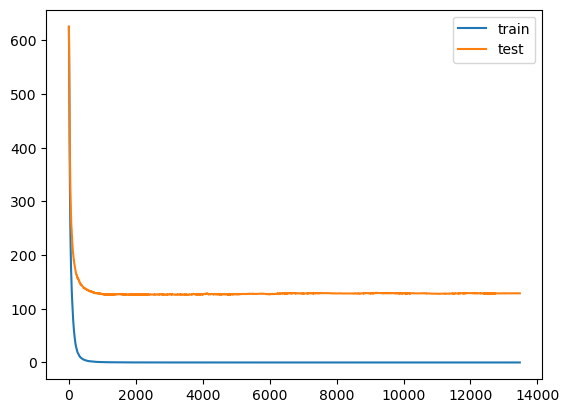

In [146]:
plt.plot(train_sse)
plt.plot(test_sse)
plt.legend(["train","test"])
print(train_sse[-1])
print(test_sse[-1])
print(classification_report(y_train,np.argmax(p,axis=1),digits=5))
print(classification_report(y_test,np.argmax(test_p,axis=1),digits=5))

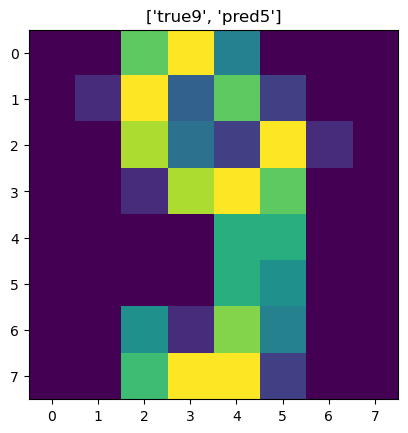

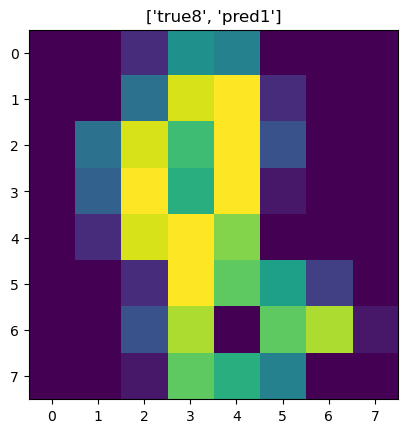

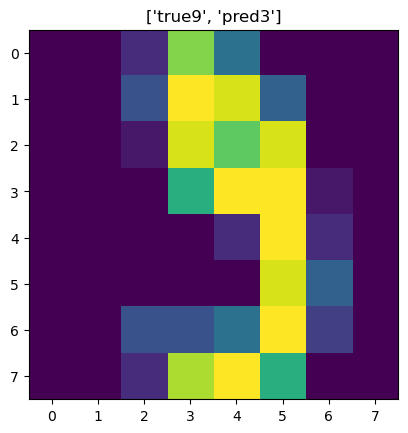

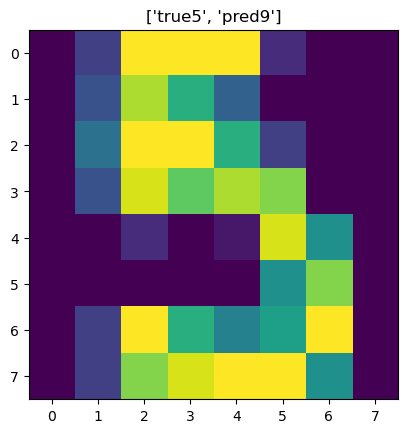

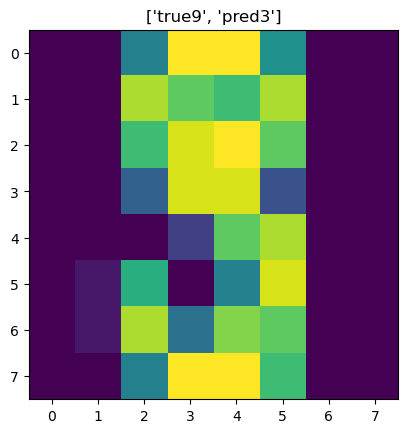

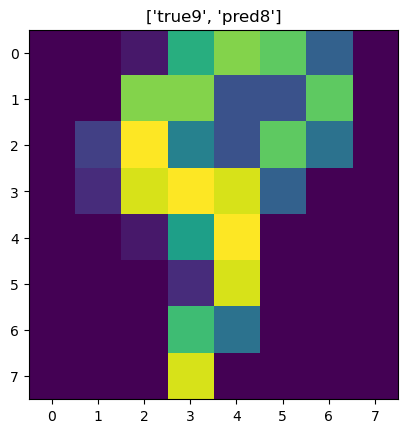

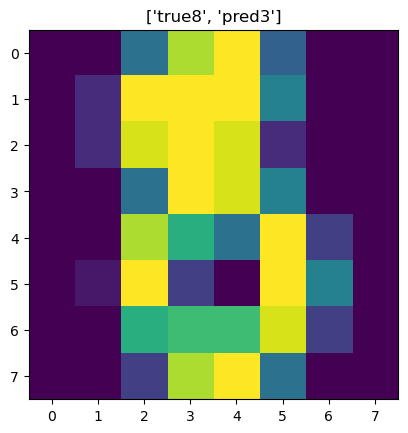

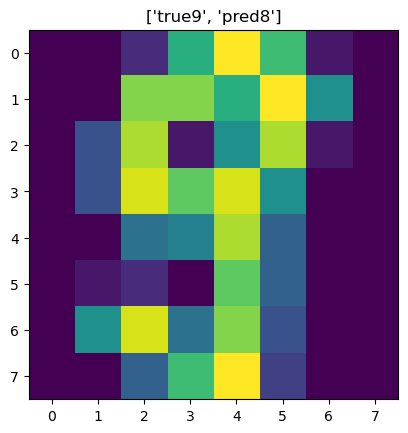

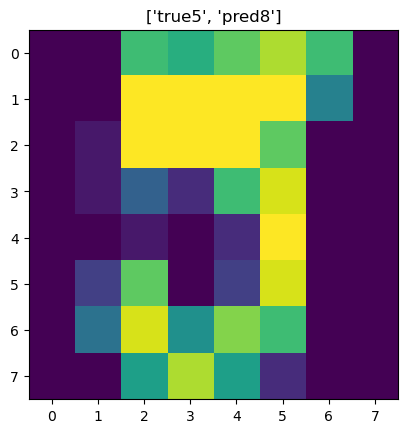

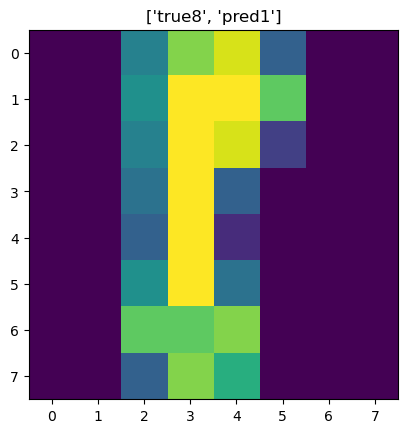

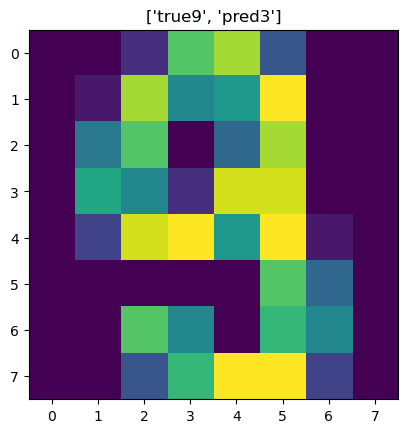

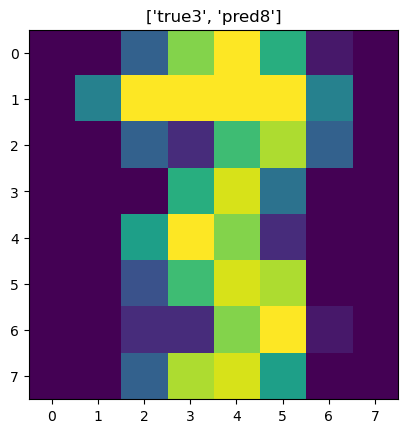

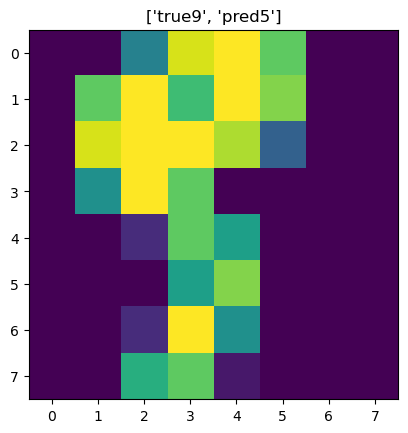

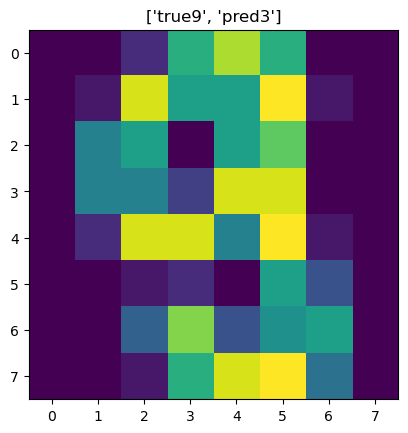

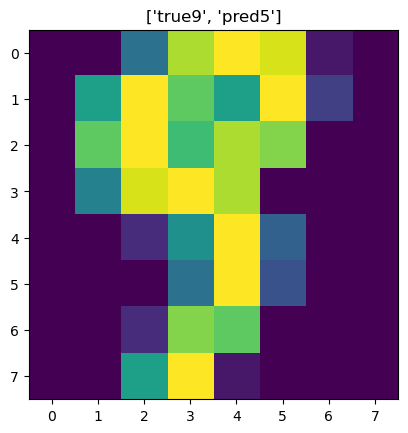

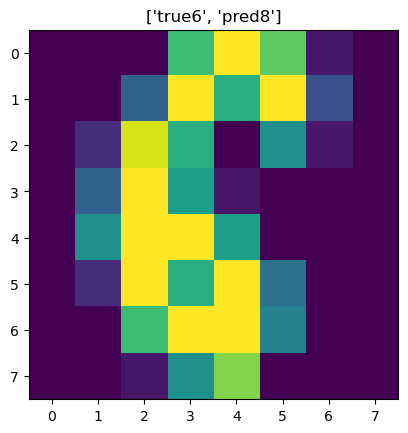

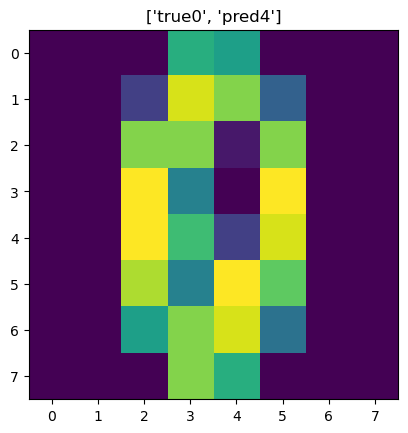

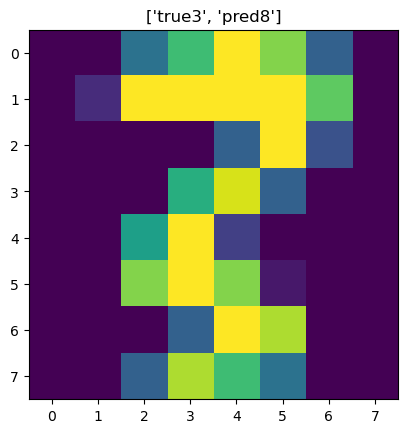

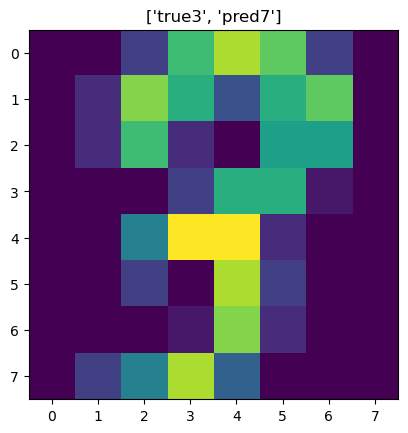

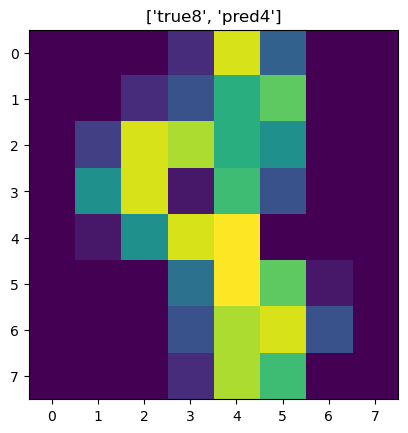

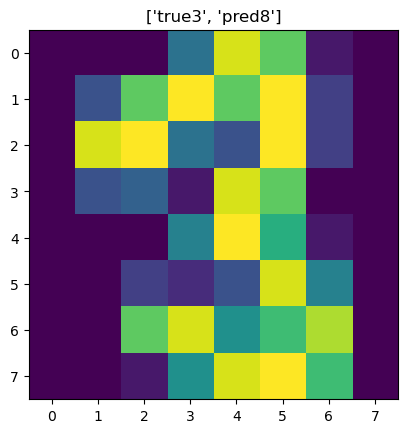

In [60]:
test_pred = np.argmax(test_p,axis=1)
miss = X_test[y_test!=test_pred,:]
miss_true = y_test[y_test!=test_pred]
miss_pred = test_pred[y_test!=test_pred]
for i in range(len(miss)):
    img = miss[i].reshape((8,8))
    plt.imshow(img)
    plt.title(["true"+str(miss_true[i]),"pred"+str(miss_pred[i])])
    plt.show()

# Decision Tree

In [119]:
from sklearn.tree import DecisionTreeClassifier

In [120]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

print(classification_report(y_train,clf.predict(X_train)))
print(classification_report(y_test,clf.predict(X_test),digits=5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        77
           2       1.00      1.00      1.00        70
           3       1.00      1.00      1.00        74
           4       1.00      1.00      1.00        67
           5       1.00      1.00      1.00        61
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        68
           8       1.00      1.00      1.00        92
           9       1.00      1.00      1.00        63

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700

              precision    recall  f1-score   support

           0    0.83784   0.80519   0.82119        77
           1    0.84146   0.87342   0.85714        79
           2    0.48684   0.54412   0.51389        68
           3    0.56757 

# XGBoost

In [153]:
import xgboost


In [154]:
# xgb = xgboost.XGBClassifier(min_child_weight=0,max_depth=10)
# xgb = xgboost.XGBClassifier(min_child_weight=0,max_depth=1)
xgb = xgboost.XGBClassifier()
xgb.fit(X_train,y_train)

print(classification_report(y_train,xgb.predict(X_train),digits=5))
print(classification_report(y_test,xgb.predict(X_test),digits=5))
print("train:",np.sum(np.power(y_train_one_hot - xgb.predict_proba(X_train),2)))
print("test:",np.sum(np.power(y_test_one_hot - xgb.predict_proba(X_test),2)))


              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      4804
           1    1.00000   1.00000   1.00000      5542
           2    1.00000   1.00000   1.00000      4837
           3    1.00000   1.00000   1.00000      4922
           4    1.00000   1.00000   1.00000      4799
           5    1.00000   1.00000   1.00000      4383
           6    1.00000   1.00000   1.00000      4857
           7    1.00000   1.00000   1.00000      5170
           8    1.00000   1.00000   1.00000      4801
           9    1.00000   1.00000   1.00000      4885

    accuracy                        1.00000     49000
   macro avg    1.00000   1.00000   1.00000     49000
weighted avg    1.00000   1.00000   1.00000     49000

              precision    recall  f1-score   support

           0    0.98387   0.98809   0.98598      2099
           1    0.98796   0.98373   0.98584      2335
           2    0.97090   0.97631   0.97360      2153
           3    0.97934 

In [155]:
import json

def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    depths = list(item_generator(json_input, 'depth'))
    return max(depths) + 1 if len(depths) != 0 else 1


booster = xgb.get_booster()

tree_df = booster.trees_to_dataframe()
depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
len(depths),np.average(depths),len(tree_df)

(1000, 5.97, 66958)

# GDBT

In [156]:
from sklearn.ensemble import GradientBoostingClassifier

In [157]:
clf = GradientBoostingClassifier()
clf.fit(X_train,y_train)

print(classification_report(y_train,clf.predict(X_train),digits=5))
print(classification_report(y_test,clf.predict(X_test),digits=5))
print("train:",np.sum(np.power(y_train_one_hot - clf.predict_proba(X_train),2)))
print("test:",np.sum(np.power(y_test_one_hot - clf.predict_proba(X_test),2)))

len(clf.estimators_),sum([ est.tree_.node_count for ests in clf.estimators_ for est in ests])

KeyboardInterrupt: 